In [164]:
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
from scipy import interpolate
import pickle
import datetime as dt
import joblib
import time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from itertools import permutations, combinations
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_tree, plot_importance
from lightgbm import LGBMRegressor
#from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor,  HistGradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings(action='ignore')
# 성능 평가
from sklearn.metrics import mean_squared_error
def RMSE(y_pred, y):
    return mean_squared_error(y_pred, y)**0.5

wr_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/*.csv")) # 2012~2021 + 2022-05-01 00:00 ~ 2022-07-18 23:50 
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv", index_col=0) # 2022-06-01 00:00	~ 2022-07-18 23:50	6912개
test_all = pd.read_csv('./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/test_all.csv')
test_all.columns = ['Unnamed: 0', 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']

# 전체 데이터프레임 결합(2012~2021년)
df_list = []
for i in wr_list:
    df_list.append(pd.read_csv(i))
df = pd.concat(df_list, ignore_index=True)

# 결측치
df['fw_1018680'] = df['fw_1018680'].fillna(0)
df['sfw_ecpc'] = 244
df = df.drop(['ymdhm.1'], axis=1)

# 날짜 전처리
def date_conv(df):
    df['ymdhm'] = pd.to_datetime(df['ymdhm'])
    #df['year'] = df['ymdhm'].dt.year
    #df['month'] =df['ymdhm'].dt.month
    #df['day'] =df['ymdhm'].dt.day
    df['hour'] =df['ymdhm'].dt.hour
    df['minute'] =df['ymdhm'].dt.minute
    #df['weekday'] = df['ymdhm'].dt.weekday
    #df['year_month_day_hour_minute'] = df['ymdhm'].dt.strftime('%Y-%m-%d-%H-%M')
    df = df.drop('ymdhm', axis=1)
    return df
df = date_conv(df)
#df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'weekday'])
df.shape

(276336, 20)

In [165]:
# 방법3 interpolate 이용한 분석
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
#Y1 = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630", 'year','month','day','hour']]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)

# train, test셋 분리
'''train_target = Y.iloc[:268704, :]
train_target1 = Y1.iloc[:268704, :]
train_data = X.iloc[:268704, :]
test_target = Y.iloc[268704:, :]
test_target1 = Y1.iloc[268704:, :]
test_data = X.iloc[268704:, :]'''

'''train_target = Y.iloc[:269394, :]
#train_target1 = Y1.iloc[:269394, :]
train_data = X.iloc[:269394, :]
test_target = Y.iloc[269394:, :]
#test_target1 = Y1.iloc[269394:, :]
test_data = X.iloc[269394:, :]
'''
train_target = Y.iloc[:269424, :]
#train_target1 = Y1.iloc[:269424, :]
train_data = X.iloc[:269424, :]
test_target = Y.iloc[269424:, :]
#test_target1 = Y1.iloc[269424:, :]
test_data = X.iloc[269424:, :]

# 팔당댐 공용량 결측치 채우기
train_data['ecpc'] = train_data['ecpc'].interpolate()
test_data['ecpc'] = test_data['ecpc'].fillna(method = 'pad')

# 팔당댐 저수량 결측치 채우기
train_data['sfw'] = 244 - train_data['ecpc']
test_data['sfw'] = 244 - test_data['ecpc']

# 나머지 결측치 채우기
train_target = train_target.interpolate()
#train_target1 = train_target1.interpolate()
train_data = train_data.interpolate()
test_data = X.iloc[269424:, :].fillna(method = 'pad')
#test_data = X.iloc[269394:, :].fillna(method = 'pad')
#test_data = test_data.iloc[11:, :]

# 총 저수량 제거
train_data = train_data.drop(columns = ['sfw_ecpc'])
test_data = test_data.drop(columns = ['sfw_ecpc'])
df = df.drop(columns = ['sfw_ecpc'])
test_target = test_all.drop(columns=['Unnamed: 0'], axis=1)

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)


(269424, 15) (269424, 4) (6912, 15) (6912, 4)


In [166]:
data1 = pd.concat([train_data, test_data], axis=0)
data1 = data1.reset_index(drop=True)
data2 = pd.concat([train_target, test_target], axis=0)
data2 = data2.reset_index(drop=True)
data3 = pd.concat([data1, data2], axis=1)

In [167]:
def preprocess_data(data, is_train=True):
    df = data.copy()
    # 1. hour, minute를 1개 항목으로(float) 병합, day 항목 제거
    df['hour'] = df['hour'] + df['minute']/60
    df.drop(['minute'], axis=1, inplace=True)
    
    # 2. sin, cos함수를 이용한 시간의 연속적 표현 
    #df['cos_time'] = np.cos(2*np.pi*(df['hour']/24))
    #df['sin_time'] = np.sin(2*np.pi*(df['hour']/24))
    
    # 3. 3일치, 5일치 평균 발전량 
    # wl_1018662 : 청담대교 
    df['wl_1018662_shft1'] = df['wl_1018662'].shift(1) # 10분 전 수위
    df['wl_1018662_shft2'] = df['wl_1018662'].shift(1*2) # 20분 전 수위
    df['wl_1018662_shft3'] = df['wl_1018662'].shift(1*3) # 30분 전 수위
    df['wl_1018662_shft4'] = df['wl_1018662'].shift(1*4) # 40분 전 수위
    df['wl_1018662_shft5'] = df['wl_1018662'].shift(1*5) # 50분 전 수위
    df['wl_1018662_shft6'] = df['wl_1018662'].shift(1*6) # 60분 전 수위
    df['wl_1018662_avg3'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1018662_avg5'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3','wl_1018662_shft4', 'wl_1018662_shft5']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018662_avg2'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1018662_avg4'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3','wl_1018662_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018662_avg6'] = np.mean(df[['wl_1018662_shft1', 'wl_1018662_shft1', 'wl_1018662_shft2', 'wl_1018662_shft3','wl_1018662_shft4', 'wl_1018662_shft5', 'wl_1018662_shft6']].values, axis=-1) # 5일치 평균 발전량 
    #df.drop(['wl_1018662_shft4', 'wl_1018662_shft5'], axis=1, inplace=True)

    # wl_1018680 : 잠수교 
    df['wl_1018680_shft1'] = df['wl_1018680'].shift(1) # 10분 전 수위
    df['wl_1018680_shft2'] = df['wl_1018680'].shift(1*2) # 20분 전 수위
    df['wl_1018680_shft3'] = df['wl_1018680'].shift(1*3) # 30분 전 수위
    df['wl_1018680_shft4'] = df['wl_1018680'].shift(1*4) # 40분 전 수위
    df['wl_1018680_shft5'] = df['wl_1018680'].shift(1*5) # 50분 전 수위
    df['wl_1018680_shft6'] = df['wl_1018680'].shift(1*6) # 60분 전 수위
    df['wl_1018680_avg3'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1018680_avg5'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3','wl_1018680_shft4', 'wl_1018680_shft5']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018680_avg2'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1018680_avg4'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3','wl_1018680_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018680_avg6'] = np.mean(df[['wl_1018680_shft1', 'wl_1018680_shft1', 'wl_1018680_shft2', 'wl_1018680_shft3','wl_1018680_shft4', 'wl_1018680_shft5', 'wl_1018680_shft6']].values, axis=-1) # 5일치 평균 발전량  
    #df.drop(['wl_1018680_shft4', 'wl_1018680_shft5'], axis=1, inplace=True)

    # wl_1018683 : 한강대교 
    df['wl_1018683_shft1'] = df['wl_1018683'].shift(1) # 10분 전 수위
    df['wl_1018683_shft2'] = df['wl_1018683'].shift(1*2) # 20분 전 수위
    df['wl_1018683_shft3'] = df['wl_1018683'].shift(1*3) # 30분 전 수위
    df['wl_1018683_shft4'] = df['wl_1018683'].shift(1*4) # 40분 전 수위
    df['wl_1018683_shft5'] = df['wl_1018683'].shift(1*5) # 50분 전 수위
    df['wl_1018683_shft6'] = df['wl_1018683'].shift(1*6) # 60분 전 수위
    df['wl_1018683_avg3'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1018683_avg5'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3','wl_1018683_shft4', 'wl_1018683_shft5']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018683_avg2'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1018683_avg4'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3','wl_1018683_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1018683_avg6'] = np.mean(df[['wl_1018683_shft1', 'wl_1018683_shft1', 'wl_1018683_shft2', 'wl_1018683_shft3','wl_1018683_shft4', 'wl_1018683_shft5', 'wl_1018683_shft6']].values, axis=-1) # 5일치 평균 발전량 
    #df.drop(['wl_1018683_shft4', 'wl_1018683_shft5'], axis=1, inplace=True)

    # wl_1019630 : 행주대교 
    df['wl_1019630_shft1'] = df['wl_1019630'].shift(1) # 10분 전 수위
    df['wl_1019630_shft2'] = df['wl_1019630'].shift(1*2) # 20분 전 수위
    df['wl_1019630_shft3'] = df['wl_1019630'].shift(1*3) # 30분 전 수위
    df['wl_1019630_shft4'] = df['wl_1019630'].shift(1*4) # 40분 전 수위
    df['wl_1019630_shft5'] = df['wl_1019630'].shift(1*5) # 50분 전 수위
    df['wl_1019630_shft6'] = df['wl_1019630'].shift(1*6) # 60분 전 수위
    df['wl_1019630_avg3'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3']].values, axis=-1) # 3일치 평균 발전량 
    df['wl_1019630_avg5'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3','wl_1019630_shft4', 'wl_1019630_shft5']].values, axis=-1) # 5일치 평균 발전량
    #df['wl_1019630_avg2'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft2']].values, axis=-1) # 3일치 평균 발전량 
    #df['wl_1019630_avg4'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3','wl_1019630_shft4']].values, axis=-1) # 5일치 평균 발전량 
    #df['wl_1019630_avg6'] = np.mean(df[['wl_1019630_shft1', 'wl_1019630_shft1', 'wl_1019630_shft2', 'wl_1019630_shft3','wl_1019630_shft4', 'wl_1019630_shft5', 'wl_1019630_shft6']].values, axis=-1) # 5일치 평균 발전량 
    #df.drop(['wl_1019630_shft4', 'wl_1019630_shft5'], axis=1, inplace=True)
    return df

df = preprocess_data(data3)
df = df.iloc[1*6:,:]
df.shape

(276330, 50)

In [168]:
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
#Y1 = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630", 'year','month','day','hour']]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)
Y = Y.reset_index(drop=True)
X = X.reset_index(drop=True)


train_target = Y.iloc[:269418, :]
#train_target1 = Y1.iloc[:269348, :]
train_data = X.iloc[:269418, :]
test_target = Y.iloc[269418:, :]

#test_target1 = Y1.iloc[269348:, :]
test_data = X.iloc[269418:, :]
test_data.iloc[:, 13:]

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(269418, 46) (269418, 4) (6912, 46) (6912, 4)


In [169]:
# swl : 팔당댐 현재수위 (단위: El.m) 0, 23~25
# inf : 팔당댐 유입량 (단위: m^3/s) -990 ~ 25991.5
# sfw : 팔당댐 저수량 (단위: 만m^3)
# ecpc : 팔당댐 공용량 (단위: 백만m^3)
# tototf : 총 방류량 (단위: m^3/s)
# tide_level : 강화대교 조위 (단위: cm)
# fw_1018662 : 청담대교 유량 (단위: m^3/s) 주소: 서울특별시 광진구 자양동
# fw_1018680 : 잠수교 유량 (단위: m^3/s) 주소: 서울특별시 서초구 반포동
# fw_1018683 : 한강대교 유량 (단위: m^3/s) 서울특별시 용산구 이촌동
# fw_1019630 : 행주대교 유량 (단위: m^3/s) 주소: 서울특별시 강서구 방화동

from itertools import permutations, combinations

target_columns1 = ['inf', 'tototf']
#target_columns2 = ['fw_1018683', 'fw_1019630', 'year', 'month']
#target_columns3 = ['rf_10184100', 'rf_10184110', 'rf_10184140']

combis1 = list(combinations(target_columns1, 2))
#combis2 = list(combinations(target_columns2, 2))
#combis3 = list(combinations(target_columns3, 2))

for com in combis1:
    train_data['{}*{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] * train_data['{}'.format(com[1])]
    test_data['{}*{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] * test_data['{}'.format(com[1])]
    train_data['{}+{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] + train_data['{}'.format(com[1])]
    test_data['{}+{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] + test_data['{}'.format(com[1])]

#for com in combis3:
#    train_data['{}*{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] * train_data['{}'.format(com[1])]
#    test_data['{}*{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] * test_data['{}'.format(com[1])]
#    train_data['{}+{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] + train_data['{}'.format(com[1])]
#    test_data['{}+{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] + test_data['{}'.format(com[1])]

#for com in combis2:
#    train_data['{}/{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] / train_data['{}'.format(com[1])]
#    test_data['{}/{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] / test_data['{}'.format(com[1])]
    
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(269418, 48) (269418, 4) (6912, 48) (6912, 4)


In [170]:
train_data = train_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018680', 'hour', 'rf_10184100', 'rf_10184110', 'rf_10184140'], axis=1)
test_data = test_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018680', 'hour', 'rf_10184100', 'rf_10184110', 'rf_10184140'], axis=1)
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269418 entries, 0 to 269417
Data columns (total 39 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   inf               269418 non-null  float64
 1   tototf            269418 non-null  float64
 2   fw_1018662        269418 non-null  float64
 3   fw_1018683        269418 non-null  float64
 4   fw_1019630        269418 non-null  float64
 5   wl_1018662_shft1  269418 non-null  float64
 6   wl_1018662_shft2  269418 non-null  float64
 7   wl_1018662_shft3  269418 non-null  float64
 8   wl_1018662_shft4  269418 non-null  float64
 9   wl_1018662_shft5  269418 non-null  float64
 10  wl_1018662_shft6  269418 non-null  float64
 11  wl_1018662_avg3   269418 non-null  float64
 12  wl_1018662_avg5   269418 non-null  float64
 13  wl_1018680_shft1  269418 non-null  float64
 14  wl_1018680_shft2  269418 non-null  float64
 15  wl_1018680_shft3  269418 non-null  float64
 16  wl_1018680_shft4  26

In [171]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
#rf.fit(train_data, train_target)
rf.fit(train_data, train_target)
pred = rf.predict(test_data)

# RMSE로 예측 평가
rmse = RMSE(pred, test_target) #2.5508483611995882
print(rmse)

sample_submission.iloc[:,:] = pred
sample_submission.to_csv('ans1.csv')
sample_submission

#,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,hour,wl_1018662,wl_1018680,wl_1018683,wl_1019630,wl_1019630_avg5  => 2.0218346640385865
# ,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,hour,wl_1018662,wl_1018680,wl_1018683,wl_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_avg3,wl_1019630_avg5 => 1.5948415817504134
# ,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,hour,wl_1018662,wl_1018680,wl_1018683,wl_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_avg3,wl_1019630_avg5 => 1.6128160550236443
# ,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_avg3,wl_1019630_avg5 => 1.5884383781692275
#,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_shft6,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_shft6,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_shft6,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_shft6,wl_1019630_avg3,wl_1019630_avg5 => 1.5814062763694907
#,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_shft6,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_shft6,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_shft6,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_shft6,wl_1019630_avg3,wl_1019630_avg5,tototf,tototf => 1.5842955270333035
# ,inf,tototf,fw_1018662,fw_1018683,fw_1019630,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_shft6,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,wl_1018680_shft2,wl_1018680_shft3,wl_1018680_shft4,wl_1018680_shft5,wl_1018680_shft6,wl_1018680_avg3,wl_1018680_avg5,wl_1018683_shft1,wl_1018683_shft2,wl_1018683_shft3,wl_1018683_shft4,wl_1018683_shft5,wl_1018683_shft6,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_shft6,wl_1019630_avg3,wl_1019630_avg5,inf*tototf, inf+tototf=> 1.5800890276510384
#



1.5800890276510384


,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,278.96,276.50,275.37,269.73
2022-06-01 00:10,280.57,276.66,273.97,267.09
2022-06-01 00:20,284.52,276.52,273.88,263.93
2022-06-01 00:30,284.95,276.84,273.65,261.47
2022-06-01 00:40,284.22,277.26,272.93,258.98
...,...,...,...,...
2022-07-18 23:10,287.26,293.67,299.55,306.55
2022-07-18 23:20,289.41,302.42,305.97,307.63
2022-07-18 23:30,298.94,306.34,308.26,308.65


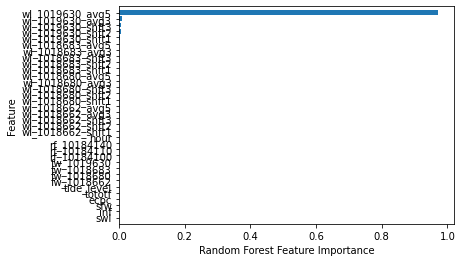

In [72]:
import matplotlib.pyplot as plt

def plot_feature_importance(model):
    n_features = train_data.shape[1]
    plt.barh(np.arange(n_features), sorted(model.feature_importances_), align="center")
    plt.yticks(np.arange(n_features), train_data.columns)
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf)

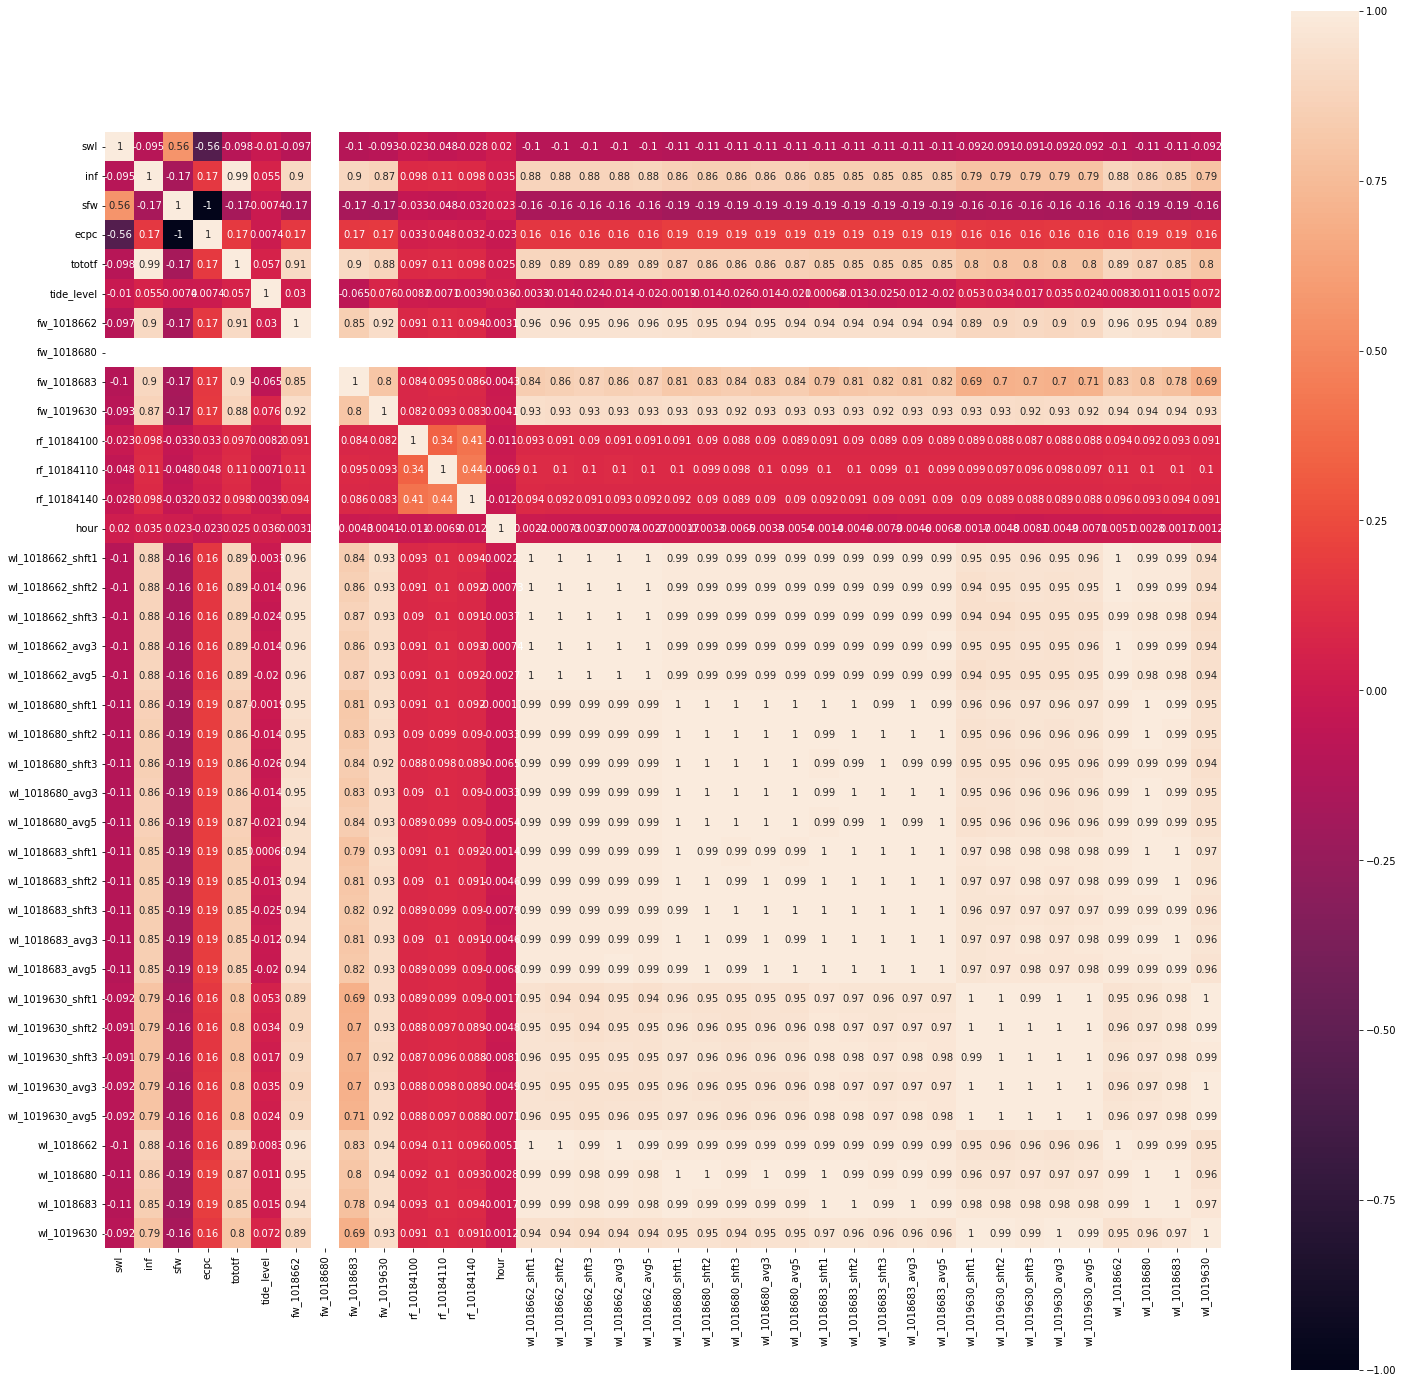

In [85]:
## chk data correlation
import seaborn as sns

f, ax = plt.subplots(figsize=(25,25))
X1 = pd.concat([train_data, train_target], axis=1)
corr = X1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, annot=True, ax=ax)

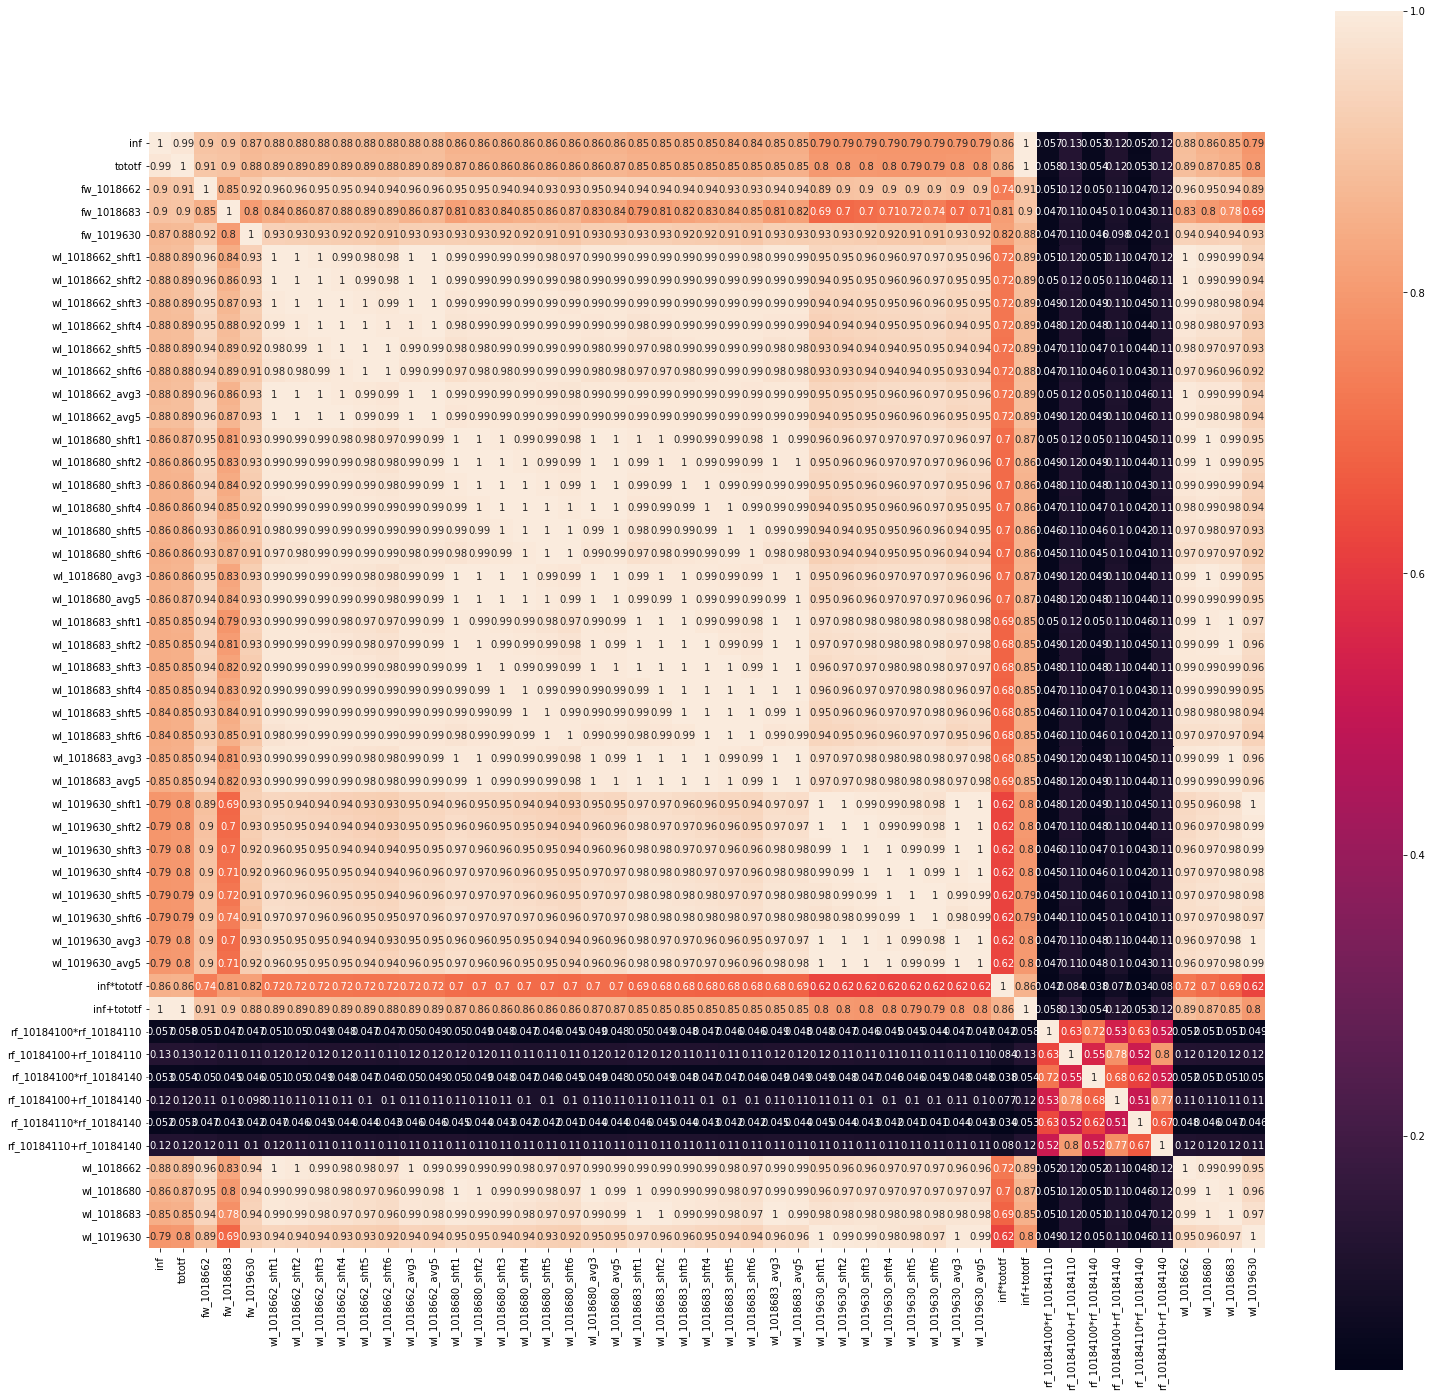

In [163]:
## chk data correlation
import seaborn as sns

f, ax = plt.subplots(figsize=(25,25))
X1 = pd.concat([train_data, train_target], axis=1)
corr = X1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, annot=True, ax=ax)

In [84]:
train_data = train_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018683', 'hour', 'rf_10184100', 'rf_10184110', 'rf10184140'], axis=1)
test_data = test_data.drop(columns = ['swl', 'sfw', 'ecpc', 'tide_level', 'fw_1018683', 'hour', 'rf_10184100', 'rf_10184110', 'rf10184140'], axis=1)



,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,...,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_avg3,wl_1019630_avg5,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,24.789,478.10,218.69,25.31,576.40,447.0,476.21,0.0,690.29,564.29,...,290.333333,277.3,276.3,275.3,276.300000,276.133333,311.7,301.2,291.0,277.3
1,24.790,464.00,218.73,25.27,562.00,442.0,483.42,0.0,666.66,564.29,...,290.500000,277.3,277.3,276.3,276.966667,276.466667,312.7,301.2,291.0,277.3
2,24.789,563.10,218.69,25.31,563.10,436.0,476.21,0.0,629.53,564.29,...,290.666667,277.3,277.3,277.3,277.300000,276.800000,311.7,301.2,291.0,277.3
3,24.789,576.40,218.69,25.31,576.40,428.0,483.42,0.0,617.71,576.54,...,290.833333,277.3,277.3,277.3,277.300000,277.133333,312.7,301.2,291.0,278.3
4,24.789,576.40,218.69,25.31,576.40,420.0,483.42,0.0,597.46,576.54,...,291.000000,278.3,277.3,277.3,277.633333,277.633333,312.7,301.2,291.0,278.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269414,25.180,140.94,217.99,26.01,140.94,220.0,285.72,0.0,575.57,493.58,...,281.666667,269.3,266.3,261.3,265.633333,264.300000,281.7,281.2,278.0,271.3
269415,25.180,141.07,217.99,26.01,141.07,208.0,274.78,0.0,501.04,505.03,...,279.833333,271.3,269.3,266.3,268.966667,266.633333,279.7,279.2,278.0,272.3
269416,25.180,141.01,217.99,26.01,141.01,196.0,269.40,0.0,425.89,505.03,...,279.166667,272.3,271.3,269.3,270.966667,268.800000,278.7,277.2,277.0,272.3
269417,25.190,755.75,218.36,25.64,140.75,184.0,264.07,0.0,198.19,493.58,...,278.333333,272.3,272.3,271.3,271.966667,270.633333,277.7,276.2,276.0,271.3


In [136]:
# 4. 순환하면서 변수 제거/후진소거법 (https://process-mining.tistory.com/138)
from sklearn.feature_selection import RFECV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

#target = train['rental']
#train1 = train.drop(['rental'], axis=1)
model = LinearRegression()
selector = RFECV(model, step=1, scoring = 'neg_mean_squared_error')
selector.fit(train_data, train_target)
selector.n_features_ # 117

train2 = selector.transform(train_data)
selected_features = train_data.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train2, columns = selected_features)
train_selected

test2 = selector.transform(test_data)
selected_features = test_data.columns[np.where(selector.ranking_==1)]
test_selected = pd.DataFrame(test2, columns = selected_features)
test_selected

,tototf,wl_1018662_shft1,wl_1018662_shft2,wl_1018662_shft3,wl_1018662_shft4,wl_1018662_shft5,wl_1018662_shft6,wl_1018662_avg3,wl_1018662_avg5,wl_1018680_shft1,...,wl_1018683_avg3,wl_1018683_avg5,wl_1019630_shft1,wl_1019630_shft2,wl_1019630_shft3,wl_1019630_shft4,wl_1019630_shft5,wl_1019630_shft6,wl_1019630_avg3,wl_1019630_avg5
0,140.60,278.7,277.7,278.7,279.7,281.7,286.7,278.366667,279.200000,276.2,...,276.000000,276.500000,270.3,271.3,272.3,272.3,271.3,269.3,271.300000,271.300000
1,140.78,279.0,278.7,277.7,278.7,279.7,281.7,278.466667,278.800000,276.0,...,275.000000,275.666667,269.0,270.3,271.3,272.3,272.3,271.3,270.200000,270.700000
2,140.90,281.0,279.0,278.7,277.7,278.7,279.7,279.566667,279.350000,277.0,...,274.333333,275.000000,267.0,269.0,270.3,271.3,272.3,272.3,268.766667,269.483333
3,140.94,284.0,281.0,279.0,278.7,277.7,278.7,281.333333,280.733333,277.0,...,274.000000,274.500000,264.0,267.0,269.0,270.3,271.3,272.3,266.666667,267.600000
4,140.63,285.0,284.0,281.0,279.0,278.7,277.7,283.333333,282.116667,277.0,...,274.000000,274.166667,261.0,264.0,267.0,269.0,270.3,271.3,264.000000,265.383333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6907,259.23,288.0,289.0,291.0,291.0,292.0,292.0,289.333333,289.833333,286.0,...,285.000000,285.166667,303.0,299.0,295.0,288.0,276.0,271.0,299.000000,294.000000
6908,260.46,288.0,288.0,289.0,291.0,291.0,292.0,288.333333,289.166667,295.0,...,290.333333,289.333333,306.0,303.0,299.0,295.0,288.0,276.0,302.666667,299.500000
6909,259.37,287.0,288.0,288.0,289.0,291.0,291.0,287.666667,288.333333,303.0,...,297.666667,293.666667,308.0,306.0,303.0,299.0,295.0,288.0,305.666667,303.166667
6910,259.13,299.0,287.0,288.0,288.0,289.0,291.0,291.333333,291.666667,307.0,...,304.000000,298.833333,310.0,308.0,306.0,303.0,299.0,295.0,308.000000,306.000000


In [135]:
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269418 entries, 0 to 269417
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tototf            269418 non-null  float64
 1   wl_1018662_shft1  269418 non-null  float64
 2   wl_1018662_shft2  269418 non-null  float64
 3   wl_1018662_shft3  269418 non-null  float64
 4   wl_1018662_shft4  269418 non-null  float64
 5   wl_1018662_shft5  269418 non-null  float64
 6   wl_1018662_shft6  269418 non-null  float64
 7   wl_1018662_avg3   269418 non-null  float64
 8   wl_1018662_avg5   269418 non-null  float64
 9   wl_1018680_shft1  269418 non-null  float64
 10  wl_1018680_shft2  269418 non-null  float64
 11  wl_1018680_shft3  269418 non-null  float64
 12  wl_1018680_shft4  269418 non-null  float64
 13  wl_1018680_shft5  269418 non-null  float64
 14  wl_1018680_shft6  269418 non-null  float64
 15  wl_1018680_avg3   269418 non-null  float64
 16  wl_1018680_avg5   26